Exploring NYC Parking Violations to answer a couple questions using sql and visualizations 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sqlalchemy import create_engine, text

csv_database = create_engine('sqlite:///csv_database.db')

In [34]:
# Import data, merge it, load it into a csv
# data_14 = pd.read_csv('Parking_Violations_2014.csv')
# print('2014 data imported')
# data_15 = pd.read_csv('Parking_Violations_2015.csv')
# print('2015 data imported')
# data_16 = pd.read_csv('Parking_Violations_2016.csv')
# print('2016 data imported')
# data_17 = pd.read_csv('Parking_Violations_2017.csv')
# print('2017 data imported')
# data_18 = pd.read_csv('Parking_Violations_2018.csv')
# print('2018 data imported')

# dataframes = [data_14, data_15, data_16, data_17, data_18]
# data = pd.concat(dataframes)
# print(data.info())

# data[data_14.columns].to_csv('Parking_Violations.csv', index = False)

# data[data_14.columns].head()

# file = 'Parking_Violations.csv'
# csv_database = create_engine('sqlite:///csv_database.db')

# chunksize = 100000
# i = 0
# j = 1
# for df in pd.read_csv(file, chunksize=chunksize, iterator=True):
#     df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) 
#     df.index += j
#     i+=1
#     df.to_sql('table', csv_database, if_exists='append')
#     j = df.index[-1] + 1

##### Columns:
['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation', 'Latitude', 'Longitude', 'Community Board',
       'Community Council ', 'Census Tract', 'BIN', 'BBL', 'NTA']
       
* Note all spaces are removed in the database

## What are the most common parking violations?

In [55]:
df0 = pd.read_sql_query(text("""
SELECT ViolationCode, Count(ViolationCode) 
FROM 'table'
GROUP BY ViolationCode
"""), csv_database)
df0.head()

,ViolationCode,Count(ViolationCode)
0,0,474
1,1,8139
2,2,685
3,3,6603
4,4,3952


In [99]:
df0.sort_values('Count(ViolationCode)', ascending = False)[:10]

,ViolationCode,Count(ViolationCode)
21,21,6814687
38,38,5440273
36,36,4177720
14,14,4104259
37,37,3091094
20,20,2905070
46,46,2553324
7,7,2443517
71,71,2396556
40,40,2261143


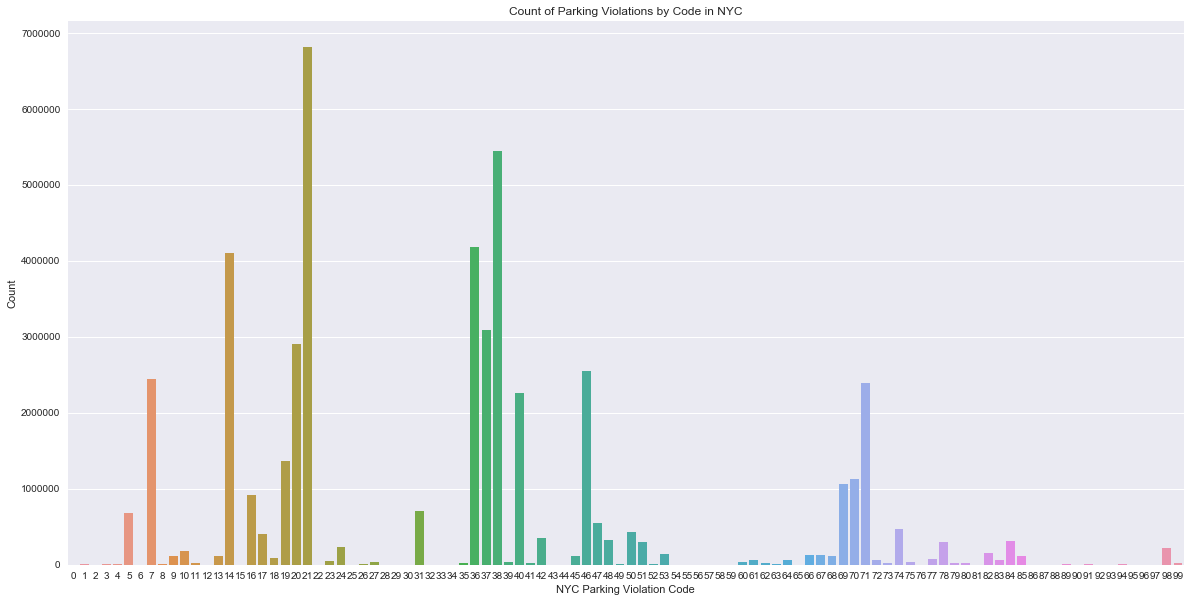

In [61]:
plt.figure(figsize = [20,10])
sns.barplot(df0['ViolationCode'], df0['Count(ViolationCode)'])
plt.xlabel('NYC Parking Violation Code')
plt.ylabel('Count')
plt.title('Count of Parking Violations by Code in NYC')
plt.show()
None

## Are there any frequent offenders? Which violations do they commit most often?

In [64]:
df1 = pd.read_sql_query(text("SELECT PlateID, ViolationCode FROM 'table'"), csv_database)
df1.head()

,PlateID,ViolationCode
0,GBB9093,46
1,62416MB,46
2,78755JZ,46
3,63009MA,46
4,91648MC,41


In [65]:
# drop rows with a null value 
df1 = df1.dropna()

# Count the number of violations per ticket
plateid_counts = df1['PlateID'].value_counts()

# Create a dictionary 
plate_count_dict = dict(zip(plateid_counts.index, plateid_counts))

# Create a column with the number of Violations given each plateid
df1['PlateViolationCount'] = df1['PlateID'].apply(lambda x: plate_count_dict[x])

# Sort plates by number of violations
df1 = df1.sort_values(by = ['PlateViolationCount'], ascending = False)

# Return the df with only the plates that had over 1000 violations since 2014
df1 = df1.loc[df1['PlateViolationCount'] > 1000]

violation_counts = df1['ViolationCode'].value_counts()

In [98]:
## attempts to get this is a single query

# df_violations = pd.read_sql_query(text("""
# SELECT ViolationCode, Count(ViolationCode)
# FROM 'table' 
# GROUP BY ViolationCode
# HAVING COUNT(PlateID) > 1000 
# ORDER BY COUNT(ViolationCode) DESC
# """), csv_database)
# df_violations.head(10)

In [66]:
df1.head()

,PlateID,ViolationCode,PlateViolationCount
37907480,BLANKPLATE,20,61321
46613679,BLANKPLATE,74,61321
27709459,BLANKPLATE,40,61321
20468049,BLANKPLATE,38,61321
37464483,BLANKPLATE,74,61321


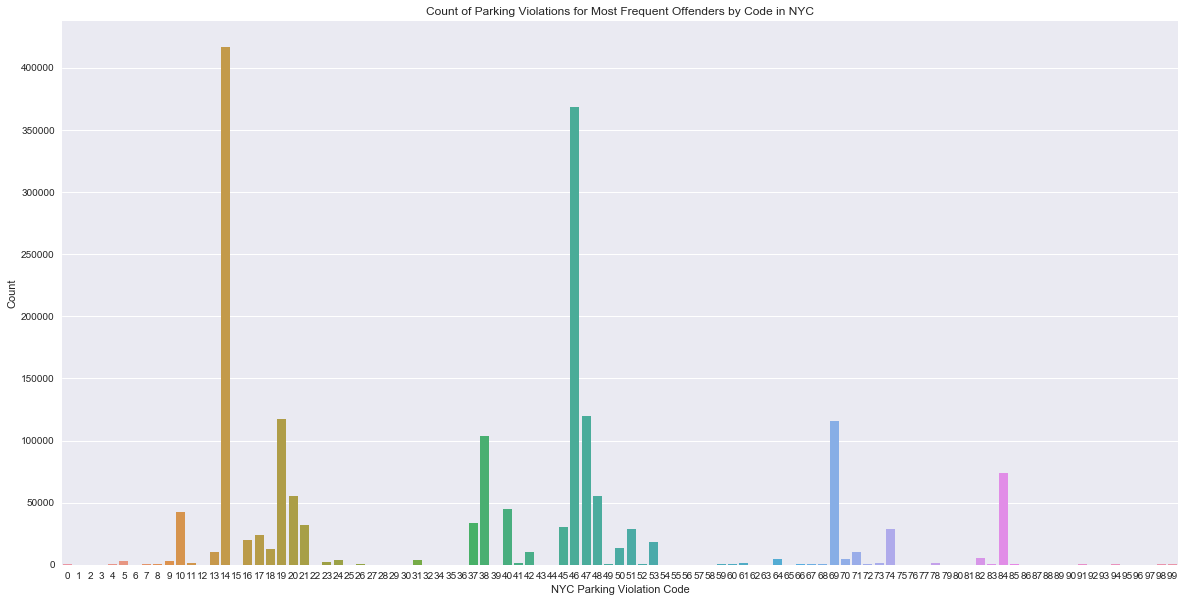

In [67]:
plt.figure(figsize = [20,10])
sns.barplot(violation_counts.index, violation_counts)
plt.xlabel('NYC Parking Violation Code')
plt.ylabel('Count')
plt.title('Count of Parking Violations for Most Frequent Offenders by Code in NYC')
plt.show()

### Who recieved the most tickets in the past four years? How much do they owe the city?

In [76]:
df_most = df1[df1['PlateID'] != 'BLANKPLATE']
df_most.head()

,PlateID,ViolationCode,PlateViolationCount
45727099,47603MD,61,4481
19456014,47603MD,47,4481
12874144,47603MD,47,4481
26426396,47603MD,47,4481
30757982,47603MD,47,4481


Fines are here:
    
http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
    
They change based on location (Above or Below 96th St, so I'll have to take latitude and longitude into account)

In [77]:
## attempts to get this is a single query

df_most = pd.read_sql_query(text("""
SELECT PlateID, Count(PlateID)
FROM 'table' 
GROUP BY PlateID
HAVING COUNT(PlateID) > 4000 
ORDER BY COUNT(ViolationCode) DESC
"""), csv_database)
df_most.head(10)

,PlateID,Count(PlateID)
0,BLANKPLATE,61321
1,47603MD,4481
2,2028685,4035


In [97]:
df_47603MD = pd.read_sql_query(text('SELECT PlateID FROM table WHERE PlateID = 47603MD'), csv_database)
df_47603MD.head()

OperationalError: (sqlite3.OperationalError) near "table": syntax error [SQL: 'SELECT PlateID FROM table WHERE PlateID = 47603MD']

## Which cars recieve the most tickets?
VehicleBodyType, VehicleMake, and VehicleColor

In [16]:
df_bodytype = pd.read_sql_query(text("""
SELECT VehicleBodyType, COUNT(VehicleBodyType) 
FROM 'table' 
GROUP BY VehicleBodyType 
ORDER BY Count(VehicleBodyType) DESC
"""), csv_database)
df_bodytype.head(10)

,VehicleBodyType,COUNT(VehicleBodyType)
0,SUBN,15724724
1,4DSD,13577033
2,VAN,6839335
3,DELV,3438983
4,SDN,2009825
5,2DSD,1272158
6,PICK,1203664
7,REFG,411200
8,TRAC,343769
9,UTIL,332988


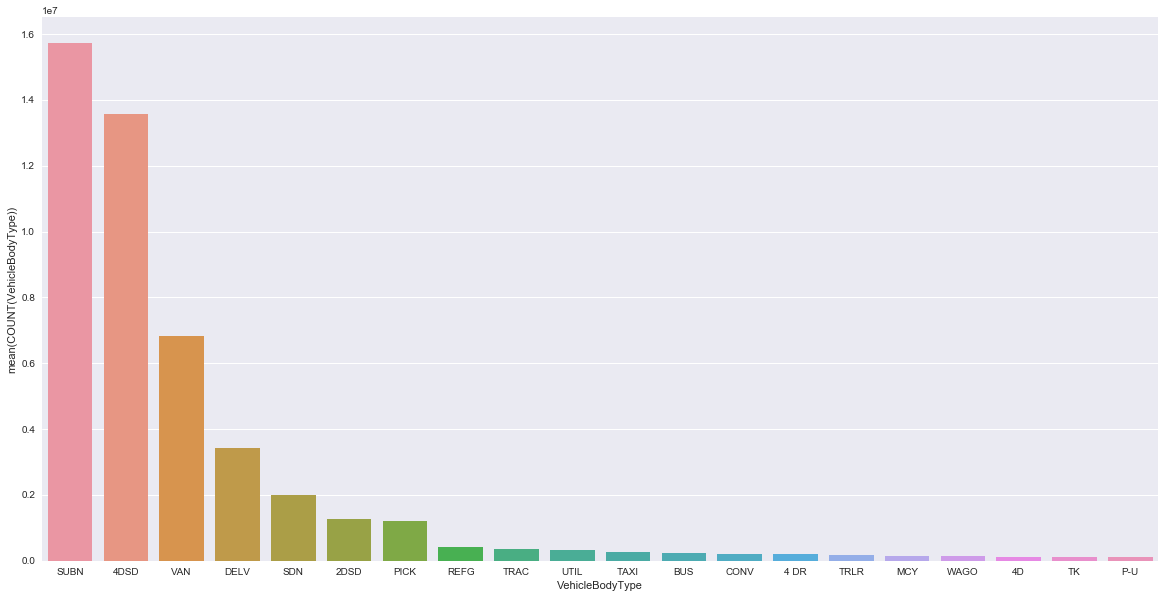

In [20]:
plt.figure(figsize = [20,10])
sns.barplot(df_bodytype['VehicleBodyType'][:20], df_bodytype['COUNT(VehicleBodyType)'][:20])
plt.xlabel('Vehicle Body Type')
plt.ylabel('Count')
plt.title('Count of Parking Violations in NYC by Body Type')
plt.show()

In [19]:
df_make = pd.read_sql_query(text("""
SELECT VehicleMake, COUNT(VehicleMake) 
FROM 'table' 
GROUP BY VehicleMake 
ORDER BY Count(VehicleMake) DESC
"""), csv_database)
df_make.head(10)

,VehicleMake,COUNT(VehicleMake)
0,FORD,6075958
1,TOYOT,5112742
2,HONDA,4586427
3,NISSA,3813625
4,CHEVR,3490220
5,FRUEH,1832266
6,ME/BE,1655443
7,DODGE,1652602
8,BMW,1572002
9,JEEP,1354308


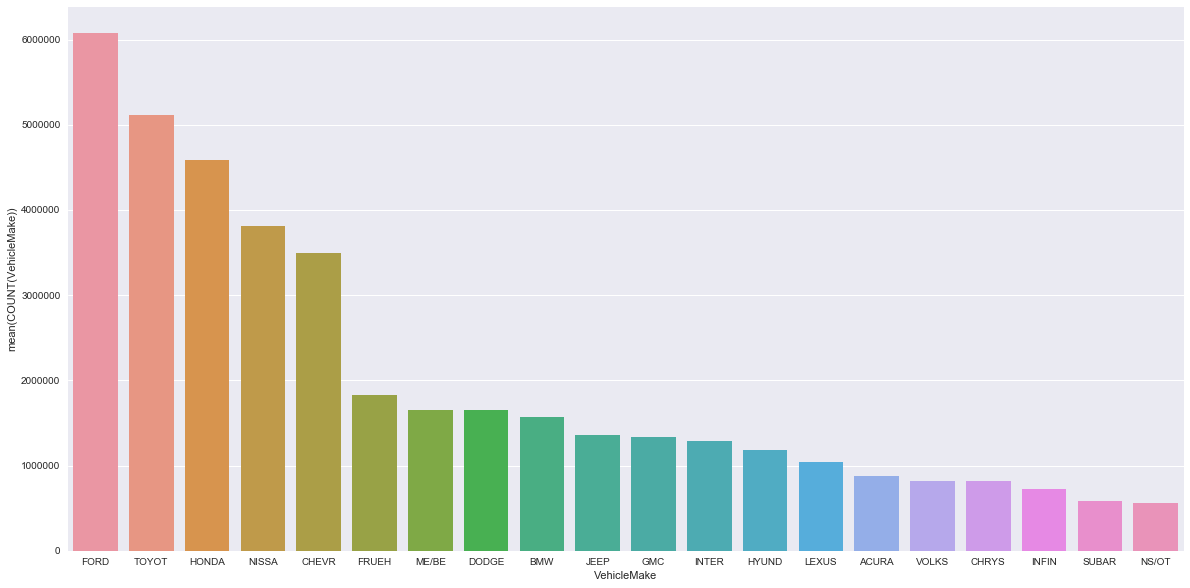

In [23]:
plt.figure(figsize = [20,10])
sns.barplot(df_make['VehicleMake'][:20], df_make['COUNT(VehicleMake)'][:20])
plt.xlabel('NYC Parking Violation Code')
plt.ylabel('Count')
plt.title('Count of Parking Violations in NYC by Vehicle Make')
plt.show()

In [25]:
df_color = pd.read_sql_query(text("""
SELECT VehicleColor, COUNT(VehicleColor) 
FROM 'table' 
GROUP BY VehicleColor 
ORDER BY COUNT(VehicleColor) DESC
"""), csv_database)
df_color.head(30)

,VehicleColor,COUNT(VehicleColor)
0,GY,7272099
1,WH,7116425
2,WHITE,6251122
3,BK,5987490
4,BLACK,3043540
5,BL,2543288
6,GREY,1845006
7,RD,1607661
8,SILVE,1373251
9,BROWN,1349191


In [42]:
def clean_color(color):
    if color == 'GY' or color == 'GRY' or color == 'GRAY':
        return('GREY')
    elif color == 'WH' or color == 'WT' or color == 'WHT' or color == 'WHI' or color == 'W':
        return('WHITE')
    elif color == 'BK':
        return('BLACK')
    elif color == 'BL' or color == 'BLU':
        return('BLUE')
    elif color == 'TN':
        return('TAN')
    elif color == 'YW':
        return('YELLO')
    elif color == 'GL' or color == 'GLD':
        return('GOLD')
    elif color == 'OR':
        return('ORANG')
    elif color == 'BR' or color == 'BRN' or color == 'BN' or color == 'BRWN' or color == 'BRO':
        return('BROWN')
    elif color == 'SL' or color == 'SIL' or color == 'SILV' or color == 'SILVR':
        return('SILVE')
    elif color == 'MR':
        return('MAROO')
    elif color == 'GR' or color == 'GRN' or color == 'GN':
        return('GREEN')
    elif color == 'PR':
        return('PURPL')
    elif color == 'RD':
        return('RED')
    else:
        return(color)
    
df_color['VehicleColor'] = df_color['VehicleColor'].apply(clean_color)

In [44]:
vehicle_colors = {}
for k, v in df_color.iterrows():
    color = v['VehicleColor']
    count = v['COUNT(VehicleColor)']
    
    if v['VehicleColor'] not in vehicle_colors:
        vehicle_colors[color] = count
    else:
        vehicle_colors[color] += count
    
df_color_2 = pd.DataFrame.from_dict(vehicle_colors, orient = 'index')
df_color_2.head(15)

,0
GREY,9588859
WHITE,13667031
BLACK,9031030
BLUE,3875136
RED,2768600
SILVE,1493666
BROWN,1812829
GREEN,1639772
TAN,905060
OTHER,491654


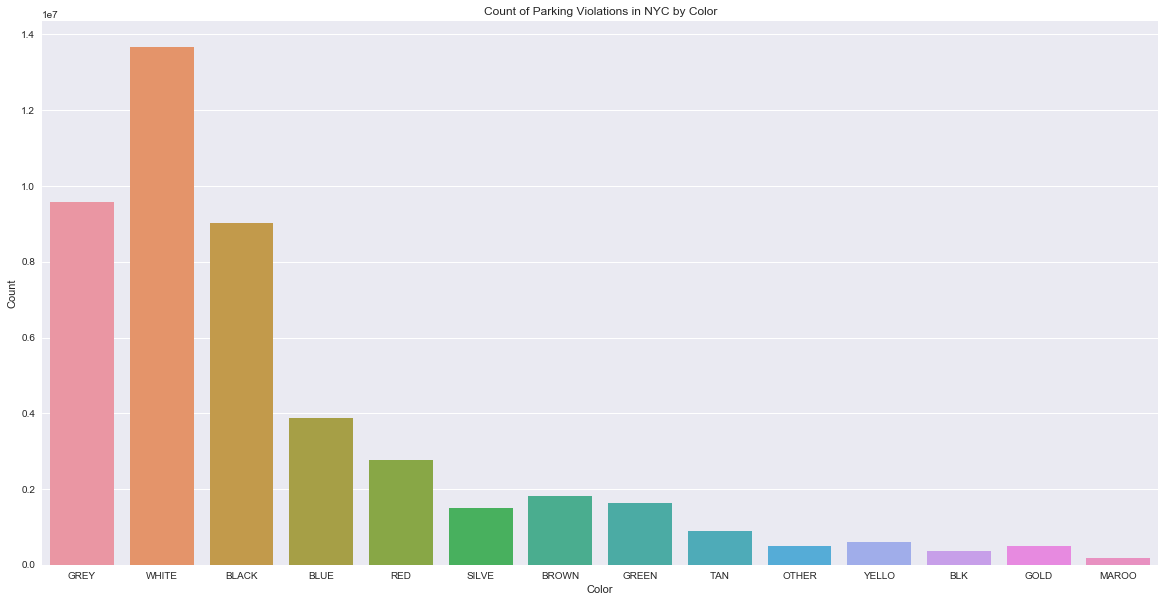

In [78]:
plt.figure(figsize = [20,10])
sns.barplot(df_color_2.index[:14], df_color_2[0][:14])
plt.xlabel('Color')
plt.ylabel('Count')
plt.title('Count of Parking Violations in NYC by Color')
plt.show()

## Where/When do most Parking Violations Happen?